In [1]:
import os
from IPython.display import clear_output

import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from ClusterDataset import ClusterDataset
from training import *
from GNN_TrackLinkingNet import GNN_TrackLinkingNet, FocalLoss, weight_init

2025-04-25 15:23:47.496115: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 15:23:47.516979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745587427.541757    1562 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745587427.549234    1562 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 15:23:47.576571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load the dataset
hist_folder_training = "/eos/user/c/czeh/histo/"
data_folder_training = "/eos/user/c/czeh/graph_data"

hist_folder_test = "/eos/user/c/czeh/histo_test/"
data_folder_test = "/eos/user/c/czeh/graph_data_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(data_folder_training, hist_folder_training)
dataset_test = ClusterDataset(data_folder_test, hist_folder_test)

In [4]:
dataset_training.get(0).edges_features

/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{

tensor([[7.0588e-01, 6.5686e+02, 0.0000e+00,  ..., 1.5688e-01, 2.5871e+00,
         1.1045e+02],
        [4.3083e-01, 6.9673e+02, 0.0000e+00,  ..., 4.7275e-01, 2.8234e+00,
         1.1045e+02],
        [3.9661e+00, 1.4818e+01, 0.0000e+00,  ..., 8.2610e-01, 3.4007e-01,
         1.1043e+02],
        ...,
        [4.7948e-01, 1.2257e+02, 0.0000e+00,  ..., 5.1068e-01, 3.1096e-01,
         0.0000e+00],
        [2.2100e+00, 8.0093e+02, 0.0000e+00,  ..., 9.3181e-01, 1.5708e+00,
         0.0000e+00],
        [1.4858e+00, 8.3549e+02, 0.0000e+00,  ..., 7.6290e-01, 1.5708e+00,
         0.0000e+00]], dtype=torch.float64)

In [5]:
train_dl = DataLoader(dataset_training, shuffle=True)
test_dl = DataLoader(dataset_test, shuffle=True)

In [6]:
epochs = 500

model = GNN_TrackLinkingNet(input_dim = dataset_training.get(0).x.shape[1], 
                                edge_feature_dim=dataset_training.get(0).edges_features.shape[1],
                                edge_hidden_dim=16, hidden_dim=16, weighted_aggr=True)
                               #dropout=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
loss_obj = FocalLoss(alpha=0.7, gamma=2)

model.apply(weight_init)

GNN_TrackLinkingNet(
  (inputnetwork): Sequential(
    (0): Linear(in_features=29, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (edge_inputnetwork): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (attention_direct): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (attention_reverse): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)


>>> Saving model to /eos/user/c/czeh/model/model_epoch_500_loss_0.3088.pt


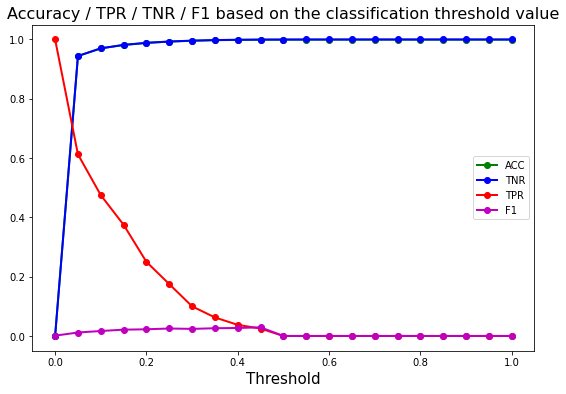

Chosen classification threshold is: 0.025
Edge labels: number of positive: 80.0
Predictions: number of positive: 12941


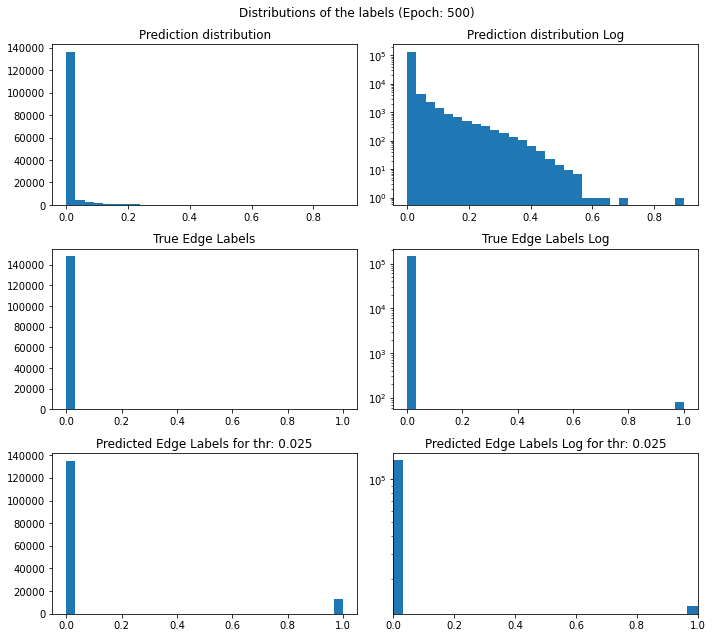

[2.33558223e-01 5.74238300e-02 1.78316282e-03 ... 1.10476045e-04
 5.73180732e-05 2.75868530e-07]
Confusion matrix:
[[135040  12882]
 [    21     59]]

Confusion matrix weighted:
[[0.45645678 0.04354322]
 [0.13125    0.36875   ]]

TN: 135040 	 FN: 21 	 TP: 59 	 FP: 12882
Confusion matrix scaled:
[[9.12420102e-01 8.70393643e-02]
 [1.41889974e-04 3.98643262e-04]]

Accuracy: 0.9128
Precision: 0.0046
Negative predictive value: 0.9998
Recall: Correctly classifying 73.7500 % of positive edges
True negative rate: Correctly classifying 91.2914 % of all negative edges
F1 score: 0.0091
[0.77667435 0.89438774] [0.91291356 0.7375    ] [0.83930116 0.80840237]
Balanced accuracy: 0.8252
Precision weighted: [0.77667435 0.89438774]
Recall weighted: [0.91291356 0.7375    ]
F1 score weighted: [0.83930116 0.80840237]
positive_likelihood_ratio: 8.468597655643533, negative_likelihood_ratio: 0.28754091380331753


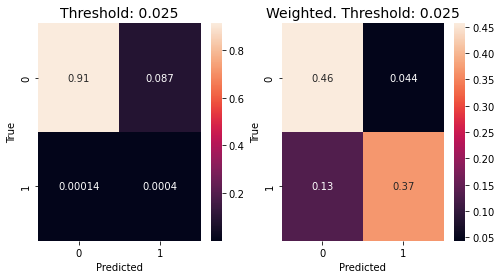

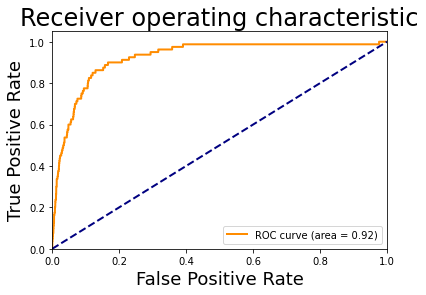

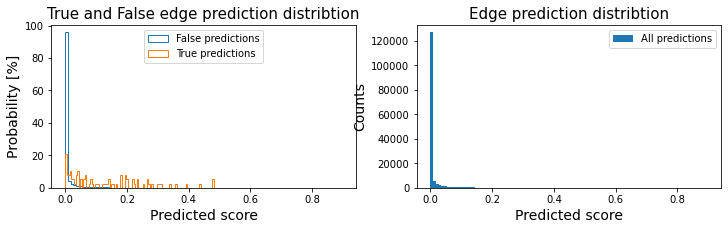

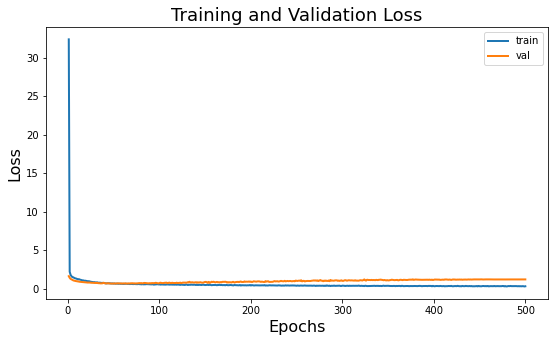

In [7]:
decision_th = 0.5
os.makedirs(model_folder, exist_ok=True)

train_loss_hist = []
val_loss_hist = []
edge_features = True

for epoch in range(epochs):
    loss = train(model, optimizer, train_dl, epoch+1, device=device, edge_features=edge_features, loss_obj=loss_obj)
    train_loss_hist.append(loss)
    print(f'Epoch: {epoch+1}, train loss: {loss:.4f}')
    
    # Validation
    model.eval()
    pred, lab = [], []
    val_loss, j = 0, 0
    print("Validation step")
    for sample in tqdm(test_dl, desc="Validation"):
        sample = sample.to(device)
        
        if edge_features:
            if sample.edge_index.shape[1] != sample.edges_features.shape[0]:
                continue
            data = prepare_network_input_data(sample.x, sample.edge_index, edge_features=sample.edges_features)
        else: 
            data = prepare_network_input_data(sample.x, sample.edge_index)
        #nn_pred, edge_emb = model(*data, device=device)
        nn_pred = model(*data, device=device)
        pred += nn_pred.tolist()
        lab += sample.y.tolist()
        val_loss += loss_obj(nn_pred, sample.y.float()).item()
        j += 1
        
    val_loss = float(val_loss)/j
    print(f'Epoch: {epoch+1}, val loss: {val_loss:.4f}')
    val_loss_hist.append(val_loss)
    
    if ((epoch - 49) % 50 == 0):
        clear_output(wait=True)
        
        print(f">>> Saving model to {model_folder + f'/model_epoch_{epoch+1}_loss_{loss:.4f}.pt'}")
        torch.save({'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, model_folder + f'/model_epoch_{epoch+1}_loss_{loss:.4f}.pt')
        
        TNR, TPR, thresholds = classification_thresholds_plot(np.array(pred), np.array(lab),
                                                              threshold_step=0.05, output_folder=model_folder,
                                                              epoch=epoch+1)
        classification_threshold = get_best_threshold(TNR, TPR, thresholds)
        print(f"Chosen classification threshold is: {classification_threshold}")

        plot_prediction_distribution_standard_and_log(np.array(pred), np.array(lab),
                                                      epoch=epoch+1, thr = classification_threshold,
                                                     folder=model_folder, val=True)

        test(np.array(lab), np.array(pred), classification_threshold=classification_threshold,
                            output_folder=model_folder, epoch=epoch+1)
        save_pred(np.array(pred), np.array(lab), epoch=epoch, out_folder=model_folder)
        save_loss(train_loss_hist, val_loss_hist, outputLossFunctionPath=model_folder)

    scheduler.step() 